In [2]:
import numpy
import pandas
from collections import Counter
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

#from google.colab import files
#uploaded = files.upload()

This first data set contains information on NY Department of Building Permits taken from NYC Open Data. https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a 

We have isolated the following fields: 
 - Borough
 - Job Type
 - Residential
 - Work Type
 - Filing Date
 - Issue Date
 - Permit Type
 - Zipcode
 - Building Type
 - Job Start Date
 - Permittee Business Name
 - Permittee License Type
 - Owner Business Type
 - Owner's House City
 - Owner's House State
 
The data set contains over 3 million rows so we're examining permits issued between Jan 2006 and Dec 2012 (may be limited further)


We also want to introduce socio-demographic data for each borough (and/or select zipcodes) along with property valuation data.

Some high level questions we want to answer include:

1. Does the trend in permit issuance follow a broader economic trend?
2. Does income and/or race correlate with property values and construction?


In [7]:
import pandas as pd

dob_permit = pd.read_csv("dob_permit_issuance_v5.csv")
dob_permit.head()
dob_permit.shape


(721559, 19)

The second data set has information about the monthly national unemployment rate from 2006 - 2010.

The third data set contains demographic information about each borough in New York City.

In [8]:
bls_unemployed = pd.read_csv("bls-unemployment-data.csv")
bls_unemployed.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2006.0,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
1,2007.0,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
2,2008.0,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
3,2009.0,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,10.0,9.9,9.9
4,2010.0,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3


# Exploratory Data Analysis and Summary Statistics
We converted the following fields to datetimes for consistency in calculation

In [9]:
dob_permit["IssueDateTime"] = pandas.to_datetime(dob_permit["Issuance Date"])

In [10]:
dob_permit["FilingDateTime"] = pandas.to_datetime(dob_permit["Filing Date"])

In [11]:
dob_permit["ExpireDateTime"] = pandas.to_datetime(dob_permit["Expiration Date"])

In [12]:
dob_permit["JobStartDateTime"] = pandas.to_datetime(dob_permit["Job Start Date"], yearfirst = True)

### Permit Wait Time

Wait time is calculated by subtracting the permit filing date from the issuance date. 


In [13]:
dob_permit['WaitTime'] = dob_permit['IssueDateTime'].sub(dob_permit['FilingDateTime'], axis=0) 

## observe rows that contain a missing Wait Time --> all are still listed as "in process"
dob_permit_missing_val = dob_permit['WaitTime'].isna()
dob_permit_missing_value = dob_permit[dob_permit_missing_val]

##dropping these rows as they are not relevant to our analysis which focuses mainly on issued or re-issued permits
dob_permit = dob_permit.dropna(subset=['WaitTime'])

dob_permit.head(5)

,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,Non-Profit,LATITUDE,LONGITUDE,CENSUS_TRACT,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime
0,MANHATTAN,A2,10017.0,2.0,NaN,SP,ISSUED,EW,SP,09/05/2006 12:00:00 AM,...,N,40.754757,-73.971554,92.0,Turtle Bay-East Midtown,2006-09-05,2006-09-05,2007-09-05,2006-09-05,0 days
1,MANHATTAN,A2,10025.0,2.0,YES,PL,ISSUED,PL,NaN,04/14/2009 12:00:00 AM,...,N,40.794233,-73.968673,181.0,Upper West Side,2009-04-17,2009-04-14,2010-04-17,2009-04-17,3 days
2,STATEN ISLAND,A1,10301.0,1.0,YES,PL,ISSUED,PL,NaN,06/27/2007 12:00:00 AM,...,Y,40.613139,-74.111129,16901.0,Westerleigh,2007-06-27,2007-06-27,2008-06-26,2007-06-27,0 days
3,BROOKLYN,A2,11234.0,2.0,NaN,MH,ISSUED,EW,MH,09/06/2007 12:00:00 AM,...,N,40.622899,-73.917609,69601.0,Georgetown-Marine Park-Bergen Beach-Mill Basin,2007-09-06,2007-09-06,2008-03-01,2007-09-06,0 days
4,MANHATTAN,A2,10014.0,2.0,NaN,PL,ISSUED,PL,NaN,10/30/2007 12:00:00 AM,...,N,40.732915,-74.002201,73.0,West Village,2007-10-30,2007-10-30,2008-10-29,2007-10-30,0 days


Here is a histogram of permit wait times

Wait time max:  4597.0 days


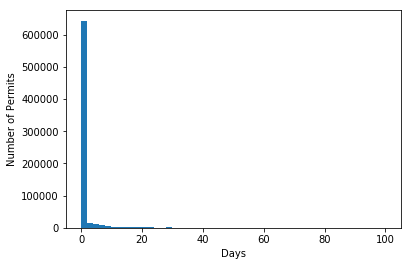

In [101]:
dob_permit["WaitTime"] = dob_permit["WaitTime"].astype('timedelta64[D]')
print("Wait time max: ", dob_permit["WaitTime"].max(), "days")

pyplot.xlabel('Days')
pyplot.ylabel('Number of Permits')
pyplot.hist(dob_permit["WaitTime"], bins = 50, range = (0,100))


pyplot.show()

Additionally, the mean permit wait time is calculated.

In [18]:
mean_wait_time = numpy.mean(dob_permit["WaitTime"])
std_wait_time = numpy.std(dob_permit["WaitTime"])

print("Mean wait time: ", mean_wait_time)
print("Std wait time: ", std_wait_time)

Mean wait time:  3.9364366145870413
Std wait time:  51.34226404337546


## Which portion of the permits are described by a geometric distribution?

In [271]:
## count the number of permits with wait time == 0.

wait_time_0 = dob_permit.WaitTime == 0
wait_time_0 = dob_permit[wait_time_0]
wait_time_0_values = wait_time_0["WaitTime"]

total = wait_time_0_values.count()

proportion_zero = total/dob_permit.WaitTime.count()

print(proportion_zero)

## counter number of permits with wait time > 0

wait_time_nonzero = dob_permit.WaitTime > 0
wait_time_nonzero= dob_permit[wait_time_nonzero]
wait_time_non_values = wait_time_nonzero["WaitTime"]

total = wait_time_non_values.count()

print(total)
proportion_nonzero = total/dob_permit.WaitTime.count()

print(proportion_nonzero)



0.8688274706867671
93903
0.13107621440536013


30.208928362246148
51.34237126292713


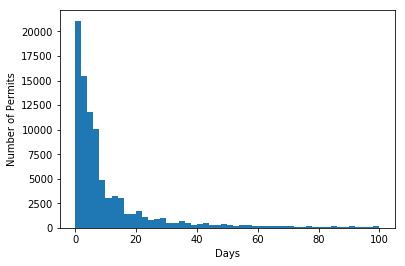

In [270]:
## histogram of portion of permits with wait time > 0

wait_time_nonzero = dob_permit.WaitTime > 0
wait_time_nonzero= dob_permit[wait_time_nonzero]

pyplot.xlabel('Days')
pyplot.ylabel('Number of Permits')
pyplot.hist(wait_time_nonzero["WaitTime"], bins = 50, range = (0,100))

mean_wait_time = numpy.mean(wait_time_nonzero["WaitTime"])
std_wait_time = numpy.std(dob_permit["WaitTime"])
print(mean_wait_time)
print(std_wait_time)
pyplot.show()

Generating a fake version of the data for comparison

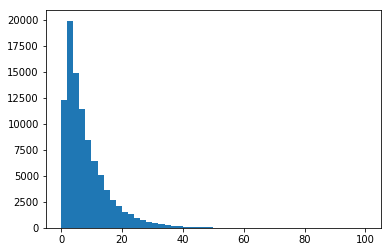

In [280]:
pyplot.hist(numpy.random.geometric(.13, size=93903),bins = 50, range = (0,100) )
pyplot.show()


### Permit Duration

Permit duration is calculated by subtracting the expiration date from the issuance date

In [19]:
dob_permit['Duration'] = dob_permit['ExpireDateTime'].sub(dob_permit['IssueDateTime'], axis=0) 
dob_permit['Duration'] = dob_permit['Duration'].astype('timedelta64[D]')

## observe rows that contain a missing Wait Time --> all are still listed as "in process"
dob_permit_missing_val = dob_permit['Duration'].isna()
dob_permit_missing_value = dob_permit[dob_permit_missing_val]

##dropping these rows as they are not relevant to our analysis which focuses mainly on issued or re-issued permits
dob_permit = dob_permit.dropna(subset=['Duration'])
dob_permit.head(5)

,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,LATITUDE,LONGITUDE,CENSUS_TRACT,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime,Duration
0,MANHATTAN,A2,10017.0,2.0,NaN,SP,ISSUED,EW,SP,09/05/2006 12:00:00 AM,...,40.754757,-73.971554,92.0,Turtle Bay-East Midtown,2006-09-05,2006-09-05,2007-09-05,2006-09-05,0.0,365.0
1,MANHATTAN,A2,10025.0,2.0,YES,PL,ISSUED,PL,NaN,04/14/2009 12:00:00 AM,...,40.794233,-73.968673,181.0,Upper West Side,2009-04-17,2009-04-14,2010-04-17,2009-04-17,3.0,365.0
2,STATEN ISLAND,A1,10301.0,1.0,YES,PL,ISSUED,PL,NaN,06/27/2007 12:00:00 AM,...,40.613139,-74.111129,16901.0,Westerleigh,2007-06-27,2007-06-27,2008-06-26,2007-06-27,0.0,365.0
3,BROOKLYN,A2,11234.0,2.0,NaN,MH,ISSUED,EW,MH,09/06/2007 12:00:00 AM,...,40.622899,-73.917609,69601.0,Georgetown-Marine Park-Bergen Beach-Mill Basin,2007-09-06,2007-09-06,2008-03-01,2007-09-06,0.0,177.0
4,MANHATTAN,A2,10014.0,2.0,NaN,PL,ISSUED,PL,NaN,10/30/2007 12:00:00 AM,...,40.732915,-74.002201,73.0,West Village,2007-10-30,2007-10-30,2008-10-29,2007-10-30,0.0,365.0


A histogram of permit durations:

Max Duration:  73259.0 days


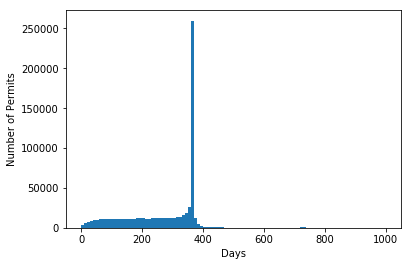

In [102]:
duration = dob_permit["Duration"]
print("Max Duration: ", duration.max(), "days")

pyplot.xlabel('Days')
pyplot.ylabel('Number of Permits')


pyplot.hist(duration, bins= 100, range = (0,1000))
pyplot.show()

The mean permit duration is as follows:

In [103]:
mean_duration= numpy.mean(dob_permit["Duration"])
std_duration = numpy.std(dob_permit["Duration"])

print("Mean duration: ", mean_duration, "days")
print("Std duration: ", std_duration, "days")

Mean duration:  272.7864740368509 days
Std duration:  153.4979660782378 days


### New Buildings and Demolitions

#### By Borough

The code NB in the "Job Type" field indicates a permit issued for a new building project, while the code DM indicates a permit issued for a demolition, A1 indicates a significant alteration project that changes the use or occupancy of the building.

We want to see how the volume and or percentages of new builds and demolitions differ by borough

In [130]:
## function that normalizes Counter objects to garner percentages
def normalizedCounter(Counter, totalItems):
    normalized_breakdown= Counter
    for i in normalized_breakdown:
        normalized_breakdown[i] /= total
    return normalized_breakdown

Counter({'A2': 208708, 'A3': 41450, 'A1': 15025, 'NB': 7224, 'SG': 3472, 'DM': 2520})


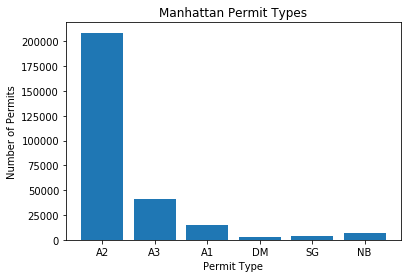

Percentages:  Counter({'A2': 0.7496722330180784, 'A3': 0.14888702904823653, 'A1': 0.05396930305065751, 'NB': 0.025948369067417626, 'SG': 0.012471309164185216, 'DM': 0.009051756651424754})


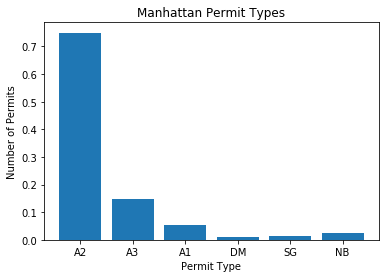

In [135]:
Manhattan = dob_permit.BOROUGH == "MANHATTAN"
manhattan = dob_permit[Manhattan]
manhattan_jobs = manhattan["Job Type"]
breakdown = Counter(manhattan_jobs)
print(breakdown)
total = manhattan_jobs.count()


##plot building permits by type


pyplot.title("Manhattan Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(breakdown.keys(), breakdown.values())
pyplot.show()

## convert to percentages
normalized = normalizedCounter(breakdown, total)
print("Percentages: ", normalized)

pyplot.title("Manhattan Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(normalized.keys(), normalized.values())
pyplot.show()



Counter({'A2': 79435, 'NB': 39950, 'A1': 24600, 'A3': 20989, 'DM': 6559, 'SG': 1607})


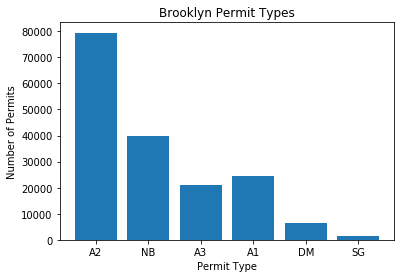

Percentages:  Counter({'A2': 0.45879057410188284, 'NB': 0.2307381309922606, 'A1': 0.14208155250086635, 'A3': 0.12122559778214162, 'DM': 0.03788263832736514, 'SG': 0.009281506295483424})


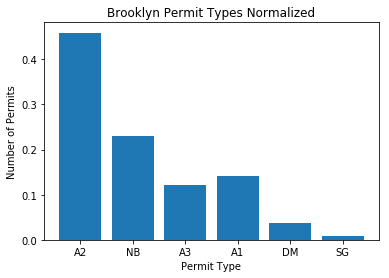

In [136]:
Brooklyn = dob_permit.BOROUGH == "BROOKLYN"
brooklyn = dob_permit[Brooklyn]
brooklyn_jobs = brooklyn["Job Type"]
breakdown = Counter(brooklyn_jobs)
total = brooklyn_jobs.count()
print(breakdown)

pyplot.title("Brooklyn Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')

pyplot.bar(breakdown.keys(), breakdown.values())
pyplot.show()

##Convert to percentages
normalized = normalizedCounter(breakdown, total)
print("Percentages: ", normalized)

pyplot.title("Brooklyn Permit Types Normalized")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(normalized.keys(), normalized.values())
pyplot.show()

Counter({'A2': 64106, 'NB': 46554, 'A1': 30998, 'A3': 15289, 'DM': 7979, 'SG': 2212})


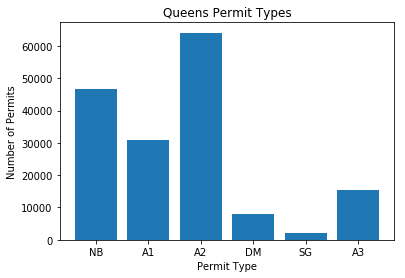

Percentages:  Counter({'A2': 0.383551316875875, 'NB': 0.27853629934545104, 'A1': 0.18546350919599372, 'A3': 0.09147530782945829, 'DM': 0.04773899412461559, 'SG': 0.0132345726286063})


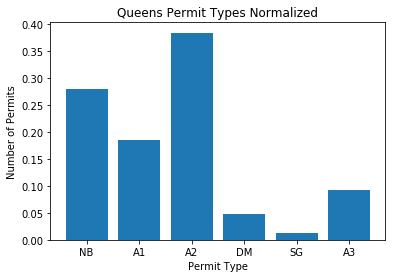

In [140]:
Queens = dob_permit.BOROUGH == "QUEENS"
queens = dob_permit[Queens]
queens_jobs = queens["Job Type"]
breakdown = Counter(queens_jobs)
total = queens_jobs.count()
print(breakdown)

pyplot.title("Queens Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')

pyplot.bar(breakdown.keys(), breakdown.values())
pyplot.show()

##Convert to percentages
normalized = normalizedCounter(breakdown, total)
print("Percentages: ", normalized)

pyplot.title("Queens Permit Types Normalized")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(normalized.keys(), normalized.values())
pyplot.show()

Counter({'A2': 27063, 'NB': 18954, 'A3': 9014, 'A1': 5131, 'DM': 1811, 'SG': 820})


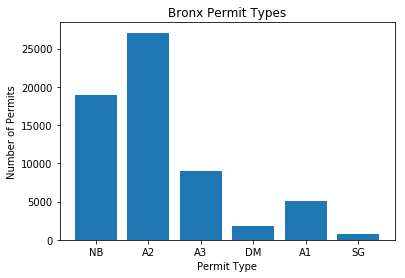

Percentages:  Counter({'A2': 0.43098753045721655, 'NB': 0.3018489322058191, 'A3': 0.14355103275842848, 'A1': 0.08171292978516714, 'DM': 0.028840794356058796, 'SG': 0.01305878043730989})


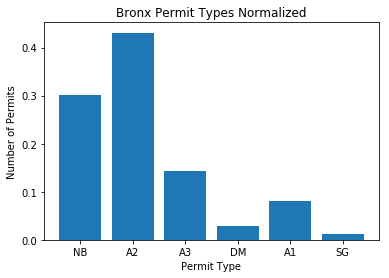

In [139]:
Bronx = dob_permit.BOROUGH == "BRONX"
bronx = dob_permit[Bronx]
bronx_jobs = bronx["Job Type"]
breakdown = Counter(bronx_jobs)
total = bronx_jobs.count()
print(breakdown)

pyplot.title("Bronx Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')

pyplot.bar(breakdown.keys(), breakdown.values())
pyplot.show()

##Convert to percentages
normalized = normalizedCounter(breakdown, total)
print("Percentages: ", normalized)

pyplot.title("Bronx Permit Types Normalized")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(normalized.keys(), normalized.values())
pyplot.show()

Counter({'NB': 14223, 'A2': 10531, 'A1': 5126, 'A3': 2509, 'DM': 1939, 'SG': 602})


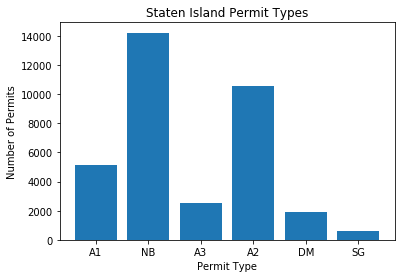

Percentages:  Counter({'NB': 0.40718580017177214, 'A2': 0.3014886916690524, 'A1': 0.14675064414543373, 'A3': 0.07182937303177785, 'DM': 0.05551102204408818, 'SG': 0.017234468937875752})


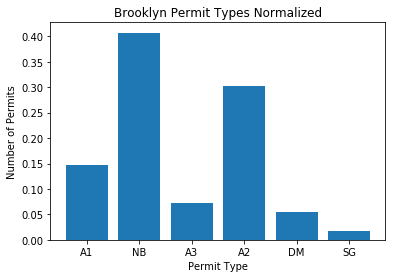

In [138]:
Staten = dob_permit.BOROUGH == "STATEN ISLAND"
staten = dob_permit[Staten]
staten_jobs = staten["Job Type"]
breakdown = Counter(staten_jobs)
total = staten_jobs.count()
print(breakdown)

pyplot.title("Staten Island Permit Types")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')

pyplot.bar(breakdown.keys(), breakdown.values())
pyplot.show()

##Convert to percentages
normalized = normalizedCounter(breakdown, total)
print("Percentages: ", normalized)

pyplot.title("Staten Island Permit Types Normalized")
pyplot.xlabel('Permit Type')
pyplot.ylabel('Number of Permits')
pyplot.bar(normalized.keys(), normalized.values())
pyplot.show()

#### Things to Note:
* Between the years of 2006 and 2010, Staten Island saw an unsually high volume of new buildings  
* All the other boroughs have a large volume of A2 alterations which include multiple types of changes that will not change use or occupancy of the building. One might consider looking at the types of work involved in these A2 renovations.

#### By Year

We are particularly interested in new builds and demolitions since the first classified as an economic indicator and the second might indicate and aging and or transforming neighborhood, which will be useful when we introduce demographic data. 

So, we want to find out how the volume of new builds and demolition varies year to year. 

In [27]:
##TODO

## Question: Does permit type affect the time it takes for a permit to be approved?

**Hypothesis**: New building projects will take longer to approve, while demolitions will take a shorter time to approve. A1 and A2 renovations may vary. Actually, this could be a toss-up, because while new buildings are longer projects, buildings up for demolition likely have to be inspected before final approval. 

**Method**: Run linear and multiple regressions on the categorical "Job Type" variable to determine the strength of the relationship. The x values will be  dummy encoded job types and the y values will be permit duration in days. 

In [287]:
##run a linear regression with the NB column as the x values

job_types = ["NB"]
wait_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["WaitTime"]])
print(wait_regression.coef_, wait_regression.intercept_)


[[1.14104231]] [3.73431327]


In [288]:
##run a linear regression with the NB column as the x values

job_types = ["DM"]
wait_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["WaitTime"]])
print(wait_regression.coef_, wait_regression.intercept_)

[[-0.76498416]] [3.95865967]


In [289]:
##run a linear regression with the NB column as the x values

job_types = ["NB", "DM", "A1", "A2", "A3"]
wait_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["WaitTime"]])
print(wait_regression.coef_, wait_regression.intercept_)


[[ 1.13485288 -0.54682719  1.89173024  0.00381232 -1.64434691]] [3.7405027]


## Question: Does permit type affect permit duration?

**Hypothesis**: New building projects will increase permit duration, while demolitions will decrease permit duration, A1 and A2 renovations may vary. 

**Method**: Run linear and multiple regressions on the categorical "Job Type" variable to determine the strength of the relationship. The x values will be  dummy encoded job types and the y values will be permit duration in days. 

In [28]:
##use dummy encoding to convert categorical variable to numerical values

job_type_dummies = pandas.get_dummies(dob_permit["Job Type"])
job_type_dummies.head()

,A1,A2,A3,DM,NB,SG
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [29]:
##run a linear regression with the NB column as the x values

job_types = ["NB"]
job_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["Duration"]])
print(job_regression.coef_, job_regression.intercept_)


[[-12.12199177]] [274.93379588]


In [30]:
##run a linear regression with the DM column as the y values

job_types = ["DM"]
job_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["Duration"]])
print(job_regression.coef_,job_regression.intercept_)

[[-52.03357571]] [274.29780101]


In [32]:
##run a multiple regression with all variables

job_types = ["DM", "NB", "A1", "A2", "SG"]
job_regression = LinearRegression().fit(job_type_dummies[job_types], dob_permit[["Duration"]])

print(job_regression.coef_,job_regression.intercept_)

[[-33.52263423   7.02494457  37.31989121  23.77387133 -34.65487284]] [255.78685953]


## Question: Does new building permit issuance correlate with the economy (unemployment rate)?

**Assumption**: Because building permits are generally classified as an early economic indicator, there will be a strong, negative relationship between building permits and the unemployment rate, which is also a widely used economic indicator. As the the employment rate rises, the number of building permits should fall.

**Method**: Run a linear regression on number of permits and unemployment rates per year. We chose to explore a range of years just before and just after the economic recession from 2007-2009, we'll be looking at the employment rates and number of new building permits from 2006-2010.

The data pulled from the U.S. Bureau of Labor Statistics contains the unemployment rate for each month in a year. In order to match that data, the number of new building permits issued per month per year will need to be counted. 

We need to modify our dataframe to extract this information. 

#### Let's graph both of these on the same plot
It's been noted that building permits are an early economic indicator, that is, it should predict future growth or declines in the economy. So let's graph the two measures and see if that holds true. We should see a dip in building permits just before a dip in the unemployment rate. 

Number of Permits Issued vs. Unemployment Rate


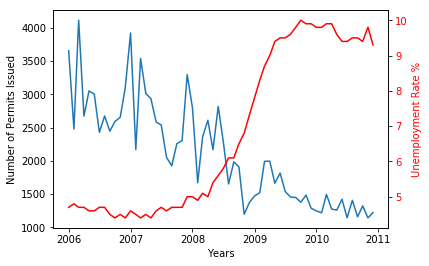

In [118]:
print("Number of Permits Issued vs. Unemployment Rate")

fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax1.plot(new_build_values[["index"]], new_build_values[["number_permits"]])
ax1.set_ylabel('Number of Permits Issued')
ax1.set_xlabel("Years")

ax2 = ax1.twinx()
ax2.plot(new_build_values[["index"]], bls_cleaned[["Percent Unemployed"]], 'r-')
ax2.set_ylabel('Unemployment Rate %', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
pyplot.show()

In [34]:
##Create new columns for date and year of issuance. 

dob_permit['Year'] = dob_permit['IssueDateTime'].dt.year
dob_permit['Month'] = dob_permit['IssueDateTime'].dt.month

## create new column for "Date"
dob_permit['IssueDate'] = pd.to_datetime(dob_permit[['Year', 'Month']].assign(Day=1))
#dob_permit['month_year'] = dob_permit['FilingDateTime'].dt.to_period('M')
dob_permit.head()

,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime,Duration,Year,Month,IssueDate
0,MANHATTAN,A2,10017.0,2.0,NaN,SP,ISSUED,EW,SP,09/05/2006 12:00:00 AM,...,Turtle Bay-East Midtown,2006-09-05,2006-09-05,2007-09-05,2006-09-05,0.0,365.0,2006,9,2006-09-01
1,MANHATTAN,A2,10025.0,2.0,YES,PL,ISSUED,PL,NaN,04/14/2009 12:00:00 AM,...,Upper West Side,2009-04-17,2009-04-14,2010-04-17,2009-04-17,3.0,365.0,2009,4,2009-04-01
2,STATEN ISLAND,A1,10301.0,1.0,YES,PL,ISSUED,PL,NaN,06/27/2007 12:00:00 AM,...,Westerleigh,2007-06-27,2007-06-27,2008-06-26,2007-06-27,0.0,365.0,2007,6,2007-06-01
3,BROOKLYN,A2,11234.0,2.0,NaN,MH,ISSUED,EW,MH,09/06/2007 12:00:00 AM,...,Georgetown-Marine Park-Bergen Beach-Mill Basin,2007-09-06,2007-09-06,2008-03-01,2007-09-06,0.0,177.0,2007,9,2007-09-01
4,MANHATTAN,A2,10014.0,2.0,NaN,PL,ISSUED,PL,NaN,10/30/2007 12:00:00 AM,...,West Village,2007-10-30,2007-10-30,2008-10-29,2007-10-30,0.0,365.0,2007,10,2007-10-01


In [36]:
##create data frame with only new builds

newbuildcondition = dob_permit['Job Type'] == "NB"
new_build = dob_permit[newbuildcondition]
new_build


,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime,Duration,Year,Month,IssueDate
6,BRONX,NB,10454.0,2.0,YES,NaN,ISSUED,NB,NaN,04/29/2010 12:00:00 AM,...,Mott Haven-Port Morris,2010-04-29,2010-04-29,2011-04-29,2008-10-24,0.0,365.0,2010,4,2010-04-01
8,BROOKLYN,NB,11228.0,1.0,YES,NaN,ISSUED,NB,NaN,08/15/2007 12:00:00 AM,...,Dyker Heights,2007-08-15,2007-08-15,2007-11-09,2007-08-15,0.0,86.0,2007,8,2007-08-01
10,QUEENS,NB,11363.0,1.0,YES,NaN,ISSUED,NB,NaN,09/12/2006 12:00:00 AM,...,Douglas Manor-Douglaston-Little Neck,2006-09-12,2006-09-12,2007-07-20,2006-09-12,0.0,311.0,2006,9,2006-09-01
22,STATEN ISLAND,NB,10305.0,1.0,YES,EQ,ISSUED,EQ,FN,12/31/2009 12:00:00 AM,...,Old Town-Dongan Hills-South Beach,2009-12-31,2009-12-31,2010-12-31,2007-11-05,0.0,365.0,2009,12,2009-12-01
27,BROOKLYN,NB,11221.0,2.0,YES,NaN,ISSUED,NB,NaN,02/23/2007 12:00:00 AM,...,Bushwick South,2007-02-23,2007-02-23,2007-06-29,2007-02-23,0.0,126.0,2007,2,2007-02-01
68,BROOKLYN,NB,11215.0,2.0,YES,PL,ISSUED,PL,NaN,10/26/2010 12:00:00 AM,...,Park Slope-Gowanus,2010-10-27,2010-10-26,2011-10-27,2010-10-27,1.0,365.0,2010,10,2010-10-01
74,QUEENS,NB,11378.0,2.0,YES,EQ,ISSUED,EQ,FN,07/21/2006 12:00:00 AM,...,Middle Village,2006-07-21,2006-07-21,2006-12-31,2005-12-12,0.0,163.0,2006,7,2006-07-01
78,QUEENS,NB,11436.0,1.0,YES,NaN,ISSUED,NB,NaN,04/07/2008 12:00:00 AM,...,Baisley Park,2008-04-07,2008-04-07,2009-06-10,2008-03-03,0.0,429.0,2008,4,2008-04-01
80,BROOKLYN,NB,11239.0,NaN,YES,NaN,ISSUED,NB,NaN,11/27/2007 12:00:00 AM,...,East New York,2007-11-27,2007-11-27,2009-12-01,2006-11-13,0.0,735.0,2007,11,2007-11-01
87,BRONX,NB,10473.0,1.0,YES,NaN,ISSUED,NB,NaN,07/18/2008 12:00:00 AM,...,Soundview-Castle Hill-Clason Point-Harding Park,2008-07-18,2008-07-18,2009-01-01,2008-06-07,0.0,167.0,2008,7,2008-07-01


In [78]:
## placing the permit counts in chronological order 

new_build_values = new_build['IssueDate'].value_counts()
new_build_values = new_build_values.reset_index(name="number_permits")
new_build_values = new_build_values.sort_values("index", ascending=True)
new_build_values = new_build_values.reset_index()
new_build_values = new_build_values.drop(["level_0"], axis=1)

##eliminate outliers

new_build_values = new_build_values.drop(new_build_values.index[[range(62,119)]])
new_build_values = new_build_values.drop(new_build_values.index[[range(0,2)]])
new_build_values = new_build_values.reset_index()
new_build_values = new_build_values.drop(["level_0"], axis=1)
new_build_values.head()



/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexes/base.py:3969: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,index,number_permits
0,2006-01-01,3652
1,2006-02-01,2477
2,2006-03-01,4111
3,2006-04-01,2671
4,2006-05-01,3050


In [39]:
## import cleaned version of bls data
import pandas as pd
bls_cleaned = pd.read_csv("bls-unemployment-data-cleaned.csv")
bls_cleaned.head()


,Year,Month,Percent Unemployed
0,2006,Jan,4.7
1,2006,Feb,4.8
2,2006,Mar,4.7
3,2006,Apr,4.7
4,2006,May,4.6


In [243]:
## run a linear regression
x_values = bls_cleaned[["Percent Unemployed"]]
y_values = new_build_values[["number_permits"]]

economy_model = LinearRegression().fit(x_values,
                                    y_values) 
print(["Coefficient", "Intercept"])
print(economy_model.coef_,economy_model.intercept_)

['Coefficient', 'Intercept']
[[-270.84185961]] [3947.17728103]


0.6513396253601451


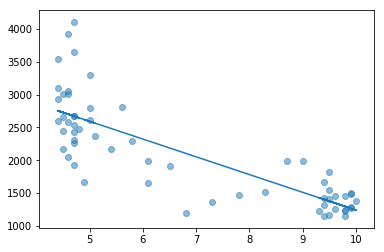

In [245]:
## finding R-squared

print(economy_model.score(x_values, y_values))
permit_predict = economy_model.predict(x_values)
pyplot.plot(x_values, permit_predict)
pyplot.scatter(x_values, y_values, alpha = 0.5)
pyplot.show()

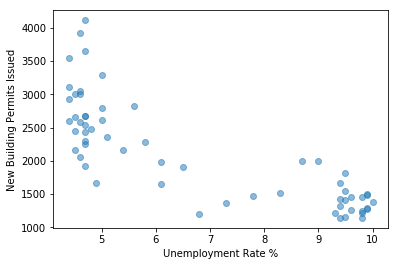

In [150]:
## graph the inputs on a scatter plot 
pyplot.scatter(x_values, y_values, alpha = 0.5)
pyplot.xlabel("Unemployment Rate %")
pyplot.ylabel("New Building Permits Issued")
pyplot.show()

### Does this finding differ between residential and commercial permits?

In [184]:
# create a dataframe with only residential new build permits
res_condition = dob_permit['Residential'] == "YES"
res_condition = dob_permit[res_condition]
res_condition

,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime,Duration,Year,Month,IssueDate
1,MANHATTAN,A2,10025.0,2.0,YES,PL,ISSUED,PL,NaN,04/14/2009 12:00:00 AM,...,Upper West Side,2009-04-17,2009-04-14,2010-04-17,2009-04-17,3.0,365.0,2009,4,2009-04-01
2,STATEN ISLAND,A1,10301.0,1.0,YES,PL,ISSUED,PL,NaN,06/27/2007 12:00:00 AM,...,Westerleigh,2007-06-27,2007-06-27,2008-06-26,2007-06-27,0.0,365.0,2007,6,2007-06-01
6,BRONX,NB,10454.0,2.0,YES,NaN,ISSUED,NB,NaN,04/29/2010 12:00:00 AM,...,Mott Haven-Port Morris,2010-04-29,2010-04-29,2011-04-29,2008-10-24,0.0,365.0,2010,4,2010-04-01
7,BROOKLYN,A2,11230.0,1.0,YES,EQ,ISSUED,EQ,FN,09/05/2008 12:00:00 AM,...,Midwood,2008-09-05,2008-09-05,2009-07-21,2008-09-05,0.0,319.0,2008,9,2008-09-01
8,BROOKLYN,NB,11228.0,1.0,YES,NaN,ISSUED,NB,NaN,08/15/2007 12:00:00 AM,...,Dyker Heights,2007-08-15,2007-08-15,2007-11-09,2007-08-15,0.0,86.0,2007,8,2007-08-01
9,BROOKLYN,A3,11236.0,2.0,YES,EQ,ISSUED,EQ,SH,08/16/2010 12:00:00 AM,...,Canarsie,2010-08-16,2010-08-16,2011-08-16,2010-08-16,0.0,365.0,2010,8,2010-08-01
10,QUEENS,NB,11363.0,1.0,YES,NaN,ISSUED,NB,NaN,09/12/2006 12:00:00 AM,...,Douglas Manor-Douglaston-Little Neck,2006-09-12,2006-09-12,2007-07-20,2006-09-12,0.0,311.0,2006,9,2006-09-01
14,STATEN ISLAND,A1,10307.0,1.0,YES,PL,ISSUED,PL,NaN,07/31/2009 12:00:00 AM,...,Charleston-Richmond Valley-Tottenville,2009-07-31,2009-07-31,2010-07-31,2002-02-27,0.0,365.0,2009,7,2009-07-01
16,STATEN ISLAND,A1,10308.0,1.0,YES,PL,ISSUED,PL,NaN,04/02/2007 12:00:00 AM,...,Great Kills,2007-04-02,2007-04-02,2008-04-01,2007-04-02,0.0,365.0,2007,4,2007-04-01
18,BROOKLYN,A2,11218.0,1.0,YES,PL,ISSUED,PL,NaN,04/12/2010 12:00:00 AM,...,Windsor Terrace,2010-04-14,2010-04-12,2011-04-14,2010-04-14,2.0,365.0,2010,4,2010-04-01


In [185]:
# create a dataframe with only commercial new build permits
com_condition = dob_permit['Residential'] != "YES"
com_condition = dob_permit[com_condition]
com_condition

,BOROUGH,Job Type,Zip Code,Bldg Type,Residential,Work Type,Permit Status,Permit Type,Permit Subtype,Filing Date,...,NTA_NAME,IssueDateTime,FilingDateTime,ExpireDateTime,JobStartDateTime,WaitTime,Duration,Year,Month,IssueDate
0,MANHATTAN,A2,10017.0,2.0,NaN,SP,ISSUED,EW,SP,09/05/2006 12:00:00 AM,...,Turtle Bay-East Midtown,2006-09-05,2006-09-05,2007-09-05,2006-09-05,0.0,365.0,2006,9,2006-09-01
3,BROOKLYN,A2,11234.0,2.0,NaN,MH,ISSUED,EW,MH,09/06/2007 12:00:00 AM,...,Georgetown-Marine Park-Bergen Beach-Mill Basin,2007-09-06,2007-09-06,2008-03-01,2007-09-06,0.0,177.0,2007,9,2007-09-01
4,MANHATTAN,A2,10014.0,2.0,NaN,PL,ISSUED,PL,NaN,10/30/2007 12:00:00 AM,...,West Village,2007-10-30,2007-10-30,2008-10-29,2007-10-30,0.0,365.0,2007,10,2007-10-01
5,MANHATTAN,A2,10065.0,2.0,NaN,PL,ISSUED,PL,NaN,08/20/2010 12:00:00 AM,...,Lenox Hill-Roosevelt Island,2010-08-20,2010-08-20,2011-08-20,2010-08-20,0.0,365.0,2010,8,2010-08-01
11,MANHATTAN,A2,10029.0,2.0,NaN,SP,ISSUED,EW,SP,06/10/2010 12:00:00 AM,...,East Harlem South,2010-06-10,2010-06-10,2011-06-10,2009-04-06,0.0,365.0,2010,6,2010-06-01
12,BRONX,A2,10459.0,2.0,NaN,PL,ISSUED,PL,NaN,03/28/2006 12:00:00 AM,...,Hunts Point,2006-03-28,2006-03-28,2007-03-28,2006-03-28,0.0,365.0,2006,3,2006-03-01
13,MANHATTAN,A2,10014.0,2.0,NaN,SP,ISSUED,EW,SP,04/16/2007 12:00:00 AM,...,West Village,2007-04-16,2007-04-16,2008-04-15,2007-04-16,0.0,365.0,2007,4,2007-04-01
15,MANHATTAN,A2,10012.0,2.0,NaN,SP,ISSUED,EW,SP,11/25/2009 12:00:00 AM,...,West Village,2009-11-25,2009-11-25,2010-11-25,2007-02-28,0.0,365.0,2009,11,2009-11-01
17,MANHATTAN,A2,10012.0,2.0,NaN,OT,ISSUED,EW,OT,04/21/2008 12:00:00 AM,...,West Village,2008-04-23,2008-04-21,2009-04-01,2007-08-16,2.0,343.0,2008,4,2008-04-01
20,BROOKLYN,A2,11211.0,2.0,NaN,PL,ISSUED,PL,NaN,07/21/2006 12:00:00 AM,...,East Williamsburg,2006-07-21,2006-07-21,2007-07-21,2006-07-21,0.0,365.0,2006,7,2006-07-01


In [269]:
## placing the permit counts in chronological order for residential

res_values = res_condition['IssueDate'].value_counts()
res_values = res_values.reset_index(name="number_permits")
res_values = res_values.sort_values("index", ascending=True)
res_values = res_values.reset_index()
res_values = res_values.drop(["level_0"], axis=1)
res_values
##eliminate outliers

res_values = res_values.drop(res_values.index[[range(63,137)]])
res_values = res_values.drop(res_values.index[[range(0,2)]])
res_values = res_values.drop(res_values.index[0])
res_values = res_values.reset_index()
res_values = res_values.drop(["level_0"], axis=1)
res_values.head()


/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexes/base.py:3969: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,index,number_permits
0,2006-01-01,4636
1,2006-02-01,3283
2,2006-03-01,5279
3,2006-04-01,3691
4,2006-05-01,4094


In [268]:
## placing the permit counts in chronological order for commercial

com_values = com_condition['IssueDate'].value_counts()
com_values = com_values.reset_index(name="number_permits")
com_values = com_values.sort_values("index", ascending=True)
com_values = com_values.reset_index()
com_values = com_values.drop(["level_0"], axis=1)
com_values

##eliminate outliers
com_values = com_values.drop(com_values.index[[range(65,134)]])
com_values = com_values.drop(com_values.index[[range(0,5)]])
#com_values = com_values.drop(com_values.index[0])
com_values = com_values.reset_index()
com_values = com_values.drop(["level_0"], axis=1)
com_values.head()

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexes/base.py:3969: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,index,number_permits
0,2006-01-01,8336
1,2006-02-01,7357
2,2006-03-01,9297
3,2006-04-01,8493
4,2006-05-01,9143


In [246]:
## run a linear regression on residential data
x_values = bls_cleaned[["Percent Unemployed"]]
y_values = res_values[["number_permits"]]

res_model = LinearRegression().fit(x_values,
                                    y_values) 
print(["Coefficient", "Intercept"])
print(res_model.coef_,res_model.intercept_)

['Coefficient', 'Intercept']
[[324.77354495]] [2435.76945342]


In [247]:
## run a linear regression on commercial data
x_values = bls_cleaned[["Percent Unemployed"]]
y_values = com_values[["number_permits"]]

com_model = LinearRegression().fit(x_values,
                                    y_values) 
print(["Coefficient", "Intercept"])
print(com_model.coef_,com_model.intercept_)

['Coefficient', 'Intercept']
[[-680.11414588]] [11889.85762287]


-3.093819459343223


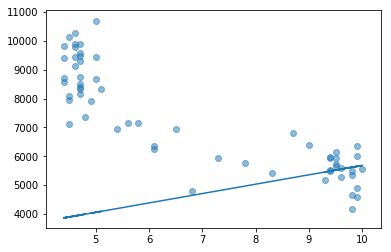

In [248]:
## r-squared for residential
print(res_model.score(x_values, y_values))
permit_predict = res_model.predict(x_values)
pyplot.plot(x_values, permit_predict)
pyplot.scatter(x_values, y_values, alpha = 0.5)
pyplot.show()

0.7531146462527041


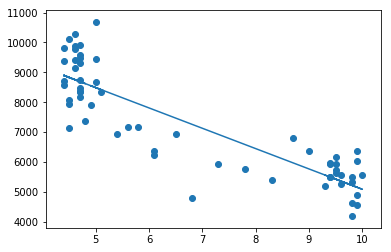

In [232]:
## r-squared for commercial 
print(com_model.score(x_values, y_values))
permit_predict = com_model.predict(x_values)
pyplot.plot(x_values, permit_predict)
pyplot.scatter(x_values, y_values)
pyplot.show()